In [148]:
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import pandas as pd
import tqdm
import numpy as np
from read_hdf5_func import read_hdf5_file, von_neumann_entropy_sv
import matplotlib.pyplot as plt

/scratch/ty296


In [149]:
# statistical functions
def mean_func(x):
    return x.mean()

def sem_func(x):
    """Standard Error of Mean"""
    return x.std() / np.sqrt(len(x))

def variance_func(x):
    return x.var()

def sev_func(x):
    """Standard Error of Variance"""
    n = len(x)
    if n <= 1:
        return np.nan
    # Standard error of variance formula
    return x.var() * np.sqrt(2 / (n - 1))

In [150]:
class data_processor:
    def __init__(self, dir_name, n, threshold):
        self.dir_name = dir_name
        self.n = n
        self.threshold = threshold
        self.df_all_data = self.df_all_data()
    
    def df_all_data(self):

        def extract_tuples(hdf5_file_path, n, threshold):
            all_data = []
            single_file_data = read_hdf5_file(hdf5_file_path, load_sv_arrays=True)
            for data_point_num in range(len(single_file_data)):
                L = single_file_data[data_point_num]['args']['L']
                p_ctrl = single_file_data[data_point_num]['p_ctrl']
                p_proj = single_file_data[data_point_num]['p_proj']
                s_0 = von_neumann_entropy_sv(single_file_data[data_point_num]['sv_arr'], n=n, positivedefinite=False, threshold=threshold)
                data_point = (L, p_ctrl, p_proj, s_0)
                all_data.append(data_point)
            return all_data
        
        df_all_data = pd.DataFrame()
        # for file_num in tqdm.tqdm(range(len(os.listdir(dir_name)))):
        for file_num in tqdm.tqdm(range(10)):
            full_name = os.path.join(self.dir_name, list(os.listdir(self.dir_name))[file_num])
            all_data = extract_tuples(full_name, n=self.n, threshold=self.threshold)
            df = pd.DataFrame(all_data, columns=['L', 'p_ctrl', 'p_proj', 's_0'])
            df_all_data = pd.concat([df_all_data, df])
        return df_all_data

    def plot(self):
        # Simple plot
        plt.figure(figsize=(10, 6))

        # Get unique L values from df_all_data
        L_values = sorted(self.df_all_data['L'].unique())
        p_vary_label = 'p_proj'
        p_fixed_label = 'p_ctrl' if p_vary_label == 'p_proj' else 'p_proj'
        p_fixed_value = self.df_all_data[p_fixed_label].unique()[0]
        y_label = 'Mean EE'
        title = f'Mean EE vs p_proj ({p_fixed_label}={p_fixed_value})'
        # Plot each L value
        for L in L_values:
            # Filter data for this L value
            L_data = self.df_all_data.query(f'L == {L}')
            
            # Group by p_proj and calculate mean and SEM
            grouped = L_data.groupby(p_vary_label)['s_0'].agg([('mean', mean_func), ('sem', sem_func), ('variance', variance_func), ('sev', sev_func)]).reset_index()
            # Plot mean with error bars
            plt.errorbar(grouped[p_vary_label], 
                        grouped['mean'], 
                        yerr=grouped['sem'], 
                        label=f'L={L}', marker='o')

        plt.xlabel(p_vary_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.savefig(f'/scratch/ty296/plots/s{self.n}_t{self.threshold}.png')
        plt.show()

    def save_plotting_data(self):
        self.df_all_data.to_csv(f'/scratch/ty296/plots/s{self.n}_t{self.threshold}.csv')


 10%|█         | 1/10 [00:00<00:03,  2.38it/s]

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


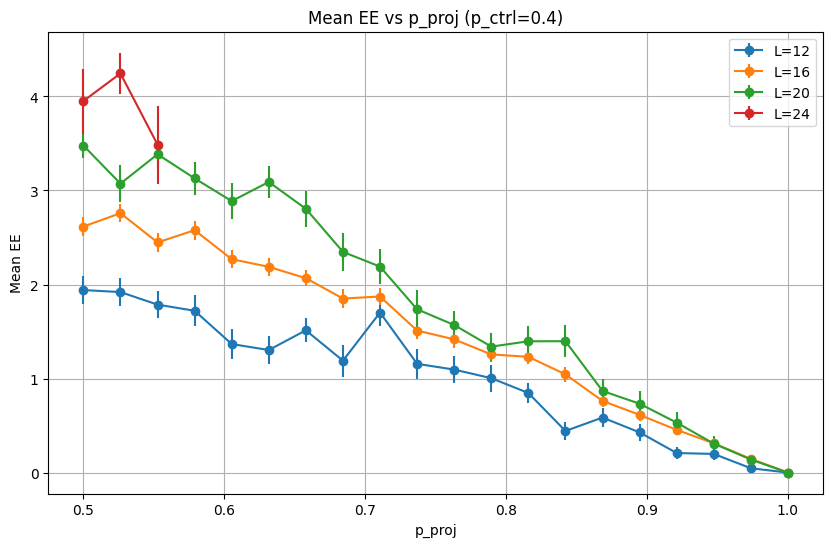

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


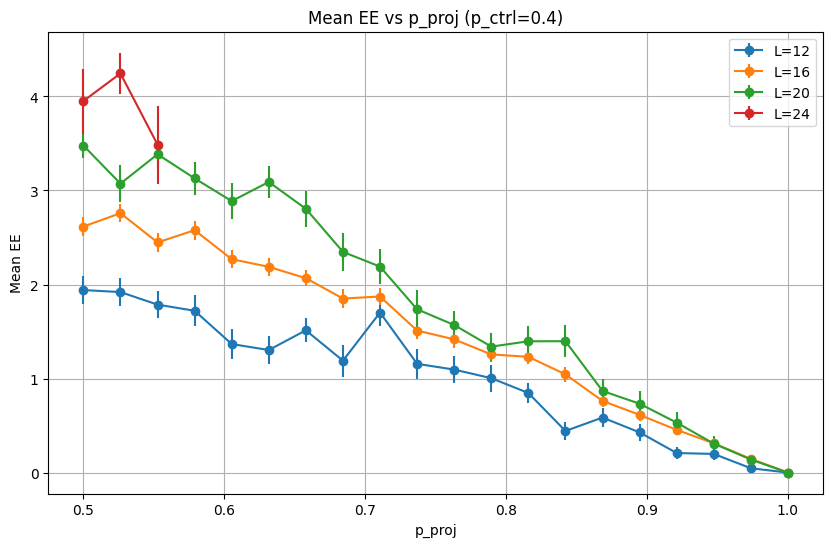

In [151]:
dir_name = '/scratch/ty296/hdf5_data/p_ctrl0.4'
for threshold in np.logspace(-16, -5, 2):
    data = data_processor(dir_name, n=0, threshold=threshold)
    data.plot()
    data.save_plotting_data()
# result = df_all_data.groupby(['L', 'p_ctrl', 'p_proj'])['s_0'].agg([
#     ('mean', mean_func),
#     ('sem', sem_func), 
#     ('variance', variance_func),
#     ('sev', sev_func)
# ])

In [152]:
(229.23+102.73) / 6.

55.32666666666666